Flow model testing

pre-load data

In [1]:
# ============================================================
# ERP Preprocessing - Tile & Reconstruct
# Run this ONCE, then use the results for all flow models
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

print("="*60)
print("ERP PREPROCESSING - TILE & RECONSTRUCT")
print("="*60)
print("This cell tiles and reconstructs your ERP images.")
print("Run this ONCE, then use the results for all optical flow models.")
print("="*60)

# ============================================================
# Helper Functions
# ============================================================

def load_image(filename):
    """Load image as numpy array"""
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def create_rectified_tiles(erp_img, tile_deg=20):
    """Create rectified tiles from ERP image"""
    H, W = erp_img.shape[:2]
    num_lon_tiles = int(360 / tile_deg)
    num_lat_tiles = int(180 / tile_deg)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * tile_deg
        lat_min = lat_max - tile_deg
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * tile_deg - 180.0
            lon_max = lon_min + tile_deg
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp_img, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_WRAP)
            tiles[lat_i][lon_j] = tile_img

    return tiles, tileWidth, tileHeight, num_lat_tiles, num_lon_tiles

# ============================================================
# Upload Images
# ============================================================

print("\n" + "="*60)
print("UPLOAD YOUR IMAGE PAIRS")
print("="*60)
print("Upload 2 consecutive ERP frames (e.g., frame1.jpg, frame2.jpg)")

from google.colab import files
uploaded = files.upload()

file_list = sorted(list(uploaded.keys()))

if len(file_list) < 2:
    print("\n⚠️ Error: Please upload at least 2 images!")
    raise ValueError("Need at least 2 images")

print(f"\n✓ Uploaded {len(file_list)} files")

# ============================================================
# Process All Image Pairs
# ============================================================

# Global storage for preprocessed data
preprocessed_pairs = []

for i in range(0, len(file_list) - 1):
    file1 = file_list[i]
    file2 = file_list[i + 1]

    print(f"\n{'='*60}")
    print(f"PREPROCESSING PAIR {i+1}: {file1} + {file2}")
    print(f"{'='*60}")

    # Load original images
    erp1 = load_image(file1)
    erp2 = load_image(file2)
    H, W, _ = erp1.shape
    print(f"Original ERP size: {H} x {W}")

    # Display input images
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(erp1)
    axes[0].set_title(f"Frame 1: {os.path.basename(file1)}")
    axes[0].axis("off")
    axes[1].imshow(erp2)
    axes[1].set_title(f"Frame 2: {os.path.basename(file2)}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # Create rectified tiles
    print(f"\n[1/2] Creating 20°×20° rectified tiles...")
    tile_deg = 20
    tiles1, tileW, tileH, n_lat, n_lon = create_rectified_tiles(erp1, tile_deg)
    tiles2, _, _, _, _ = create_rectified_tiles(erp2, tile_deg)
    total_tiles = n_lat * n_lon
    print(f"✓ Tile size: {tileH} x {tileW}")
    print(f"✓ Grid: {n_lat} x {n_lon} = {total_tiles} tiles")

    # Reconstruct ERP from tiles
    print(f"\n[2/2] Reconstructing ERP from tiles...")
    erp1_reconstructed = np.vstack([np.hstack(row) for row in tiles1])
    erp2_reconstructed = np.vstack([np.hstack(row) for row in tiles2])
    H_recon, W_recon = erp1_reconstructed.shape[:2]
    print(f"✓ Reconstructed ERP shape: {H_recon} x {W_recon}")

    # Show reconstructed ERP
    plt.figure(figsize=(14, 7))
    plt.imshow(erp1_reconstructed)
    plt.title(f"Reconstructed ERP from 20°×20° Rectified Tiles (Pair {i+1})")
    plt.axis("off")
    plt.show()

    # Store preprocessed data
    pair_data = {
        'pair_id': i + 1,
        'file1': file1,
        'file2': file2,
        'original_erp1': erp1,
        'original_erp2': erp2,
        'reconstructed_erp1': erp1_reconstructed,
        'reconstructed_erp2': erp2_reconstructed,
        'original_size': (H, W),
        'reconstructed_size': (H_recon, W_recon),
        'tile_info': {
            'tile_width': tileW,
            'tile_height': tileH,
            'n_lat': n_lat,
            'n_lon': n_lon,
            'total_tiles': total_tiles
        }
    }

    preprocessed_pairs.append(pair_data)
    print(f"✓ Pair {i+1} preprocessed and stored")

# ============================================================
# Summary
# ============================================================

print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)
print(f"\n✅ Preprocessed {len(preprocessed_pairs)} image pair(s)")
print(f"✅ Data stored in variable: preprocessed_pairs")
print(f"\nYou can now run any optical flow model and it will use this preprocessed data.")
print(f"Available models: RAFT, PWC-Net, FlowNet2, LiteFlowNet, FastFlowNet")
print("="*60)

# Display summary
for pair in preprocessed_pairs:
    print(f"\nPair {pair['pair_id']}:")
    print(f"  Files: {pair['file1']} → {pair['file2']}")
    print(f"  Original size: {pair['original_size'][0]} x {pair['original_size'][1]}")
    print(f"  Reconstructed size: {pair['reconstructed_size'][0]} x {pair['reconstructed_size'][1]}")
    print(f"  Tiles: {pair['tile_info']['total_tiles']} ({pair['tile_info']['n_lat']}x{pair['tile_info']['n_lon']})")

ERP PREPROCESSING - TILE & RECONSTRUCT
This cell tiles and reconstructs your ERP images.
Run this ONCE, then use the results for all optical flow models.

UPLOAD YOUR IMAGE PAIRS
Upload 2 consecutive ERP frames (e.g., frame1.jpg, frame2.jpg)


ModuleNotFoundError: No module named 'google.colab'

RAFT

SETTING UP ENVIRONMENT

Installing dependencies...

SETTING UP RAFT MODEL
Cloning RAFT repository...
Cloning into '/content/RAFT'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 155 (delta 1), reused 0 (delta 0), pack-reused 148 (from 3)
Receiving objects: 100% (155/155), 10.02 MiB | 38.44 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/RAFT

--2025-11-17 03:08:31--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  95.1MB/s    in 0.8s    

2025-11-17 03:08:33 (95.1 MB/s) - ‘models.zip’ saved 

Saving OZOaN_5ymrc_0024.jpg to OZOaN_5ymrc_0024.jpg
Saving OZOaN_5ymrc_0025.jpg to OZOaN_5ymrc_0025.jpg

✓ Uploaded 2 files

Processing pair 1: OZOaN_5ymrc_0024.jpg + OZOaN_5ymrc_0025.jpg

Processing: OZOaN_5ymrc_0024.jpg → OZOaN_5ymrc_0025.jpg
Model: RAFT
Original ERP size: 2048 x 3840


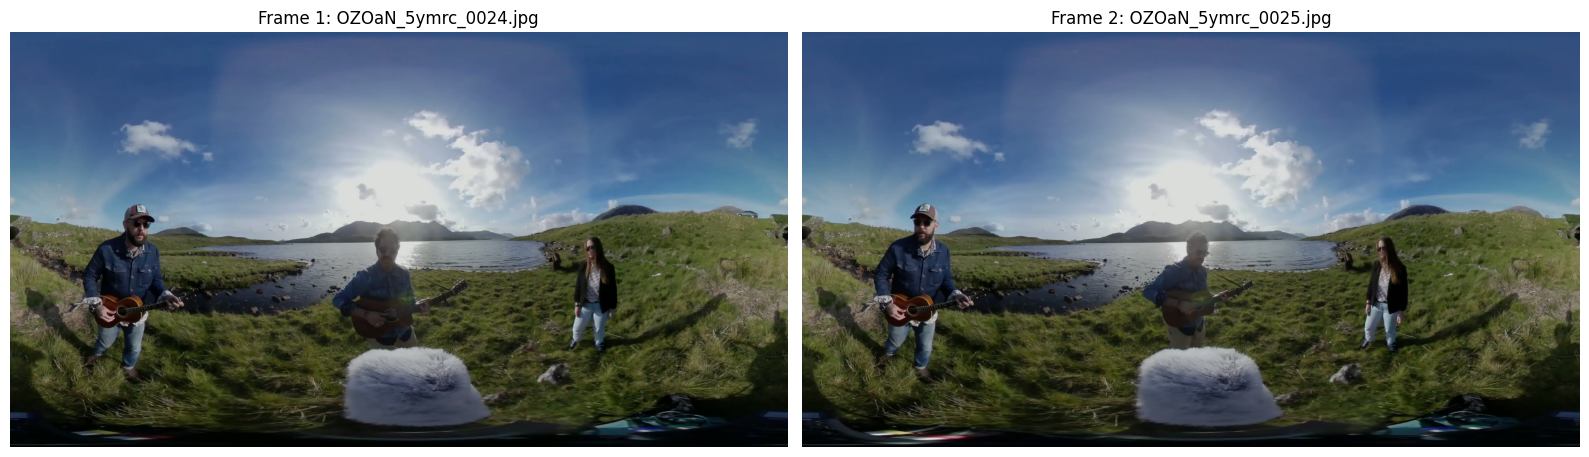


[1/3] Creating 20°×20° rectified tiles...
Tile size: 228 x 213
Grid: 9 x 18 = 162 tiles

[2/3] Reconstructing ERP from tiles...
Reconstructed ERP shape: 2052 x 3834


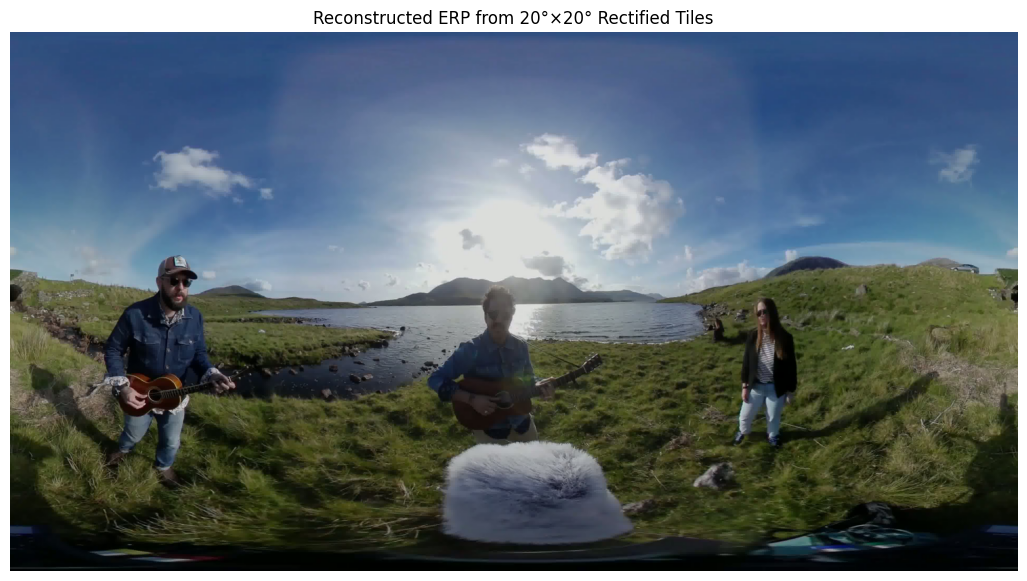


[3/3] Running RAFT on reconstructed ERP...


/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


OutOfMemoryError: CUDA out of memory. Tried to allocate 56.69 GiB. GPU 0 has a total capacity of 14.74 GiB of which 13.09 GiB is free. Process 8575 has 1.65 GiB memory in use. Of the allocated memory 822.59 MiB is allocated by PyTorch, and 745.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# ============================================================
# 360° ERP Image Pair → Optical Flow Analysis with RAFT
# Tiled Reconstruction → Single Flow Heatmap
# ============================================================

# ============================================================
# STEP 1: Setup Environment & Dependencies
# ============================================================

print("="*60)
print("SETTING UP ENVIRONMENT")
print("="*60)

# Ensure we're in /content directory
import os
os.chdir('/content')

# Install dependencies
print("\nInstalling dependencies...")
!pip install -q torch torchvision opencv-python matplotlib Pillow einops==0.4.1 scipy

# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import sys

# ============================================================
# STEP 2: Clone and Setup RAFT
# ============================================================

print("\n" + "="*60)
print("SETTING UP RAFT MODEL")
print("="*60)

# Clean previous installations
!rm -rf /content/RAFT

# Clone RAFT repository
print("Cloning RAFT repository...")
!git clone https://github.com/princeton-vl/RAFT.git /content/RAFT

# Change to RAFT directory
%cd /content/RAFT

# Download pre-trained models
print("\nDownloading pre-trained models...")
!bash download_models.sh

# Go back to content
%cd /content

# Add RAFT to Python path
sys.path.append('/content/RAFT/core')

# Import torch after setup
import torch
import torch.nn.functional as F

# Import RAFT modules
print("Importing RAFT modules...")
from raft import RAFT
from utils.utils import InputPadder

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {DEVICE}")

# ============================================================
# STEP 3: Load RAFT Model
# ============================================================

print("\nLoading RAFT model...")

import argparse
args = argparse.Namespace()
args.small = False
args.mixed_precision = False
args.alternate_corr = False

# Initialize model
model = torch.nn.DataParallel(RAFT(args))

# Load weights (using raft-sintel.pth from download_models.sh)
model_path = '/content/RAFT/models/raft-sintel.pth'
if not os.path.exists(model_path):
    model_path = '/content/RAFT/models/raft-things.pth'  # fallback

print(f"Loading weights from: {model_path}")
checkpoint = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(checkpoint)
model = model.module.to(DEVICE).eval()

print("✅ RAFT model loaded successfully!")

# ============================================================
# STEP 4: Helper Functions
# ============================================================

def load_image(filename):
    """Load image as numpy array"""
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def flow_to_heatmap(flow):
    """Convert optical flow to color heatmap (HSV)"""
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]

    # Calculate magnitude and angle
    mag = np.sqrt(fx**2 + fy**2)
    ang = np.arctan2(fy, fx)

    # Create HSV image
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ((ang + np.pi) * (180 / np.pi / 2)).astype(np.uint8)  # Hue = direction
    hsv[..., 1] = 255  # Full saturation
    hsv[..., 2] = np.clip(mag * 10, 0, 255).astype(np.uint8)  # Value = magnitude

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag

def flow_magnitude_heatmap(mag):
    """Convert flow magnitude to normalized heatmap"""
    mag_norm = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    return mag_norm

def create_rectified_tiles(erp_img, tile_deg=20):
    """Create rectified tiles from ERP image"""
    H, W = erp_img.shape[:2]
    num_lon_tiles = int(360 / tile_deg)
    num_lat_tiles = int(180 / tile_deg)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * tile_deg
        lat_min = lat_max - tile_deg
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * tile_deg - 180.0
            lon_max = lon_min + tile_deg
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp_img, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_WRAP)
            tiles[lat_i][lon_j] = tile_img

    return tiles, tileWidth, tileHeight, num_lat_tiles, num_lon_tiles

def run_raft_flow(img1_tensor, img2_tensor):
    """Run RAFT optical flow"""
    padder = InputPadder(img1_tensor.shape)
    img1_pad, img2_pad = padder.pad(img1_tensor, img2_tensor)

    with torch.no_grad():
        flow_low, flow_up = model(img1_pad, img2_pad, iters=20, test_mode=True)

    flow = flow_up[0].permute(1, 2, 0).cpu().numpy()
    return flow

# ============================================================
# STEP 5: Main Processing Function
# ============================================================

def process_image_pair_raft(file1, file2, tile_deg=20):
    """Process a pair of ERP images for optical flow analysis with RAFT"""

    print("\n" + "="*60)
    print(f"Processing: {os.path.basename(file1)} → {os.path.basename(file2)}")
    print(f"Model: RAFT")
    print("="*60)

    # Load images
    erp1 = load_image(file1)
    erp2 = load_image(file2)
    H, W, _ = erp1.shape
    print(f"Original ERP size: {H} x {W}")

    # Display input images
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(erp1)
    axes[0].set_title(f"Frame 1: {os.path.basename(file1)}")
    axes[0].axis("off")
    axes[1].imshow(erp2)
    axes[1].set_title(f"Frame 2: {os.path.basename(file2)}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # ========================================
    # STEP 1: Create Rectified Tiles
    # ========================================
    print(f"\n[1/3] Creating {tile_deg}°×{tile_deg}° rectified tiles...")
    tiles1, tileW, tileH, n_lat, n_lon = create_rectified_tiles(erp1, tile_deg)
    tiles2, _, _, _, _ = create_rectified_tiles(erp2, tile_deg)
    total_tiles = n_lat * n_lon
    print(f"Tile size: {tileH} x {tileW}")
    print(f"Grid: {n_lat} x {n_lon} = {total_tiles} tiles")

    # ========================================
    # STEP 2: Reconstruct ERP from Tiles
    # ========================================
    print(f"\n[2/3] Reconstructing ERP from tiles...")
    erp1_reconstructed = np.vstack([np.hstack(row) for row in tiles1])
    erp2_reconstructed = np.vstack([np.hstack(row) for row in tiles2])
    H_recon, W_recon = erp1_reconstructed.shape[:2]
    print(f"Reconstructed ERP shape: {H_recon} x {W_recon}")

    # Show reconstructed ERP
    plt.figure(figsize=(14, 7))
    plt.imshow(erp1_reconstructed)
    plt.title(f"Reconstructed ERP from {tile_deg}°×{tile_deg}° Rectified Tiles")
    plt.axis("off")
    plt.show()

    # ========================================
    # STEP 3: Run RAFT on Reconstructed ERP
    # ========================================
    print(f"\n[3/3] Running RAFT on reconstructed ERP...")
    start_time = time.time()

    # Convert reconstructed images to tensors
    img1_tensor = torch.from_numpy(erp1_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)

    flow = run_raft_flow(img1_tensor, img2_tensor)

    processing_time = time.time() - start_time
    print(f"✓ Optical flow computed in {processing_time:.3f}s")

    # ========================================
    # STEP 4: Generate Heatmaps
    # ========================================
    print(f"\nGenerating heatmaps...")

    # Color-coded flow (direction + magnitude)
    flow_vis, mag = flow_to_heatmap(flow)

    # Magnitude heatmap
    mag_norm = flow_magnitude_heatmap(mag)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Original reconstructed frame
    axes[0].imshow(erp1_reconstructed)
    axes[0].set_title("Reconstructed ERP (Frame 1)")
    axes[0].axis("off")

    # Color-coded optical flow
    axes[1].imshow(flow_vis)
    axes[1].set_title("RAFT Optical Flow\n(Color=Direction, Brightness=Magnitude)")
    axes[1].axis("off")

    # Magnitude heatmap
    im = axes[2].imshow(mag_norm, cmap="hot")
    axes[2].set_title("Flow Magnitude Heatmap")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Additional standalone heatmap
    plt.figure(figsize=(14, 7))
    plt.imshow(mag_norm, cmap="inferno")
    plt.title("RAFT Flow Magnitude Heatmap (Inferno Colormap)")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    # ========================================
    # Summary Statistics
    # ========================================
    print("\n" + "-"*60)
    print("RAFT FLOW STATISTICS")
    print("-"*60)
    print(f"\n📊 Flow Metrics:")
    print(f"  Mean magnitude:      {np.mean(mag):.4f} pixels")
    print(f"  Max magnitude:       {np.max(mag):.4f} pixels")
    print(f"  Median magnitude:    {np.median(mag):.4f} pixels")
    print(f"  Std deviation:       {np.std(mag):.4f} pixels")

    print(f"\n⏱️  Processing Time:")
    print(f"  Total time:          {processing_time:.3f}s")
    print(f"  Image dimensions:    {H_recon} x {W_recon}")
    print(f"  Tiles used:          {total_tiles} ({n_lat}x{n_lon})")
    print("-" * 60)

    return {
        "model": "RAFT",
        "flow": flow,
        "magnitude": mag,
        "magnitude_normalized": mag_norm,
        "processing_time": processing_time,
        "dimensions": (H_recon, W_recon),
        "tiles_count": total_tiles
    }

# ============================================================
# STEP 6: Upload and Process Images
# ============================================================

print("\n" + "="*60)
print("UPLOAD YOUR IMAGE PAIRS")
print("="*60)
print("Upload 2 consecutive ERP frames (e.g., frame1.jpg, frame2.jpg)")
print("Supported formats: .jpg, .png, .jpeg")

from google.colab import files
uploaded = files.upload()

file_list = sorted(list(uploaded.keys()))

if len(file_list) < 2:
    print("\n⚠️ Error: Please upload at least 2 images!")
else:
    print(f"\n✓ Uploaded {len(file_list)} files")

    # Process pairs
    results = []
    for i in range(0, len(file_list) - 1):
        file1 = file_list[i]
        file2 = file_list[i + 1]

        print(f"\n{'='*60}")
        print(f"Processing pair {i+1}: {file1} + {file2}")
        print(f"{'='*60}")

        result = process_image_pair_raft(file1, file2, tile_deg=20)
        results.append(result)

    # ========================================
    # Final Summary
    # ========================================
    if results:
        print("\n" + "="*60)
        print("FINAL SUMMARY - RAFT MODEL")
        print("="*60)

        for idx, result in enumerate(results, 1):
            print(f"\nPair {idx}:")
            print(f"  Processing time:   {result['processing_time']:.3f}s")
            print(f"  Image size:        {result['dimensions'][0]} x {result['dimensions'][1]}")
            print(f"  Mean flow:         {np.mean(result['magnitude']):.4f} pixels")
            print(f"  Max flow:          {np.max(result['magnitude']):.4f} pixels")

PWC

In [ ]:
# ============================================================
# 360° ERP Image Pair → Optical Flow Analysis with PWC-Net
# Tiled Reconstruction → Single Flow Heatmap
# ============================================================

# ============================================================
# STEP 1: Setup Environment & Dependencies
# ============================================================

print("="*60)
print("SETTING UP ENVIRONMENT")
print("="*60)

# Ensure we're in /content directory
import os
os.chdir('/content')

# Install dependencies
print("\nInstalling dependencies...")
!pip install -q torch torchvision opencv-python matplotlib Pillow scipy cupy-cuda11x

# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import sys

# ============================================================
# STEP 2: Clone and Setup PWC-Net
# ============================================================

print("\n" + "="*60)
print("SETTING UP PWC-NET MODEL")
print("="*60)

# Clean previous installations
!rm -rf /content/pytorch-pwc

# Clone PWC-Net repository
print("Cloning PWC-Net repository...")
!git clone https://github.com/sniklaus/pytorch-pwc.git /content/pytorch-pwc

# Change to PWC directory
%cd /content/pytorch-pwc

# Download pre-trained model
print("\nDownloading pre-trained model...")
!wget -q -O network-default.pytorch http://content.sniklaus.com/github/pytorch-pwc/network-default.pytorch

# Go back to content
%cd /content

# Add PWC to Python path
sys.path.append('/content/pytorch-pwc')

# Import torch after setup
import torch
import torch.nn.functional as F

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {DEVICE}")

# ============================================================
# STEP 3: Load PWC-Net Model
# ============================================================

print("\nLoading PWC-Net model...")

# Clear sys.argv to prevent getopt errors from run.py
original_argv = sys.argv.copy()
sys.argv = ['']

try:
    from run import Network as PWCNet
finally:
    sys.argv = original_argv

pwc_model = PWCNet().to(DEVICE).eval()

# Load weights
model_path = '/content/pytorch-pwc/network-default.pytorch'
print(f"Loading weights from: {model_path}")
state_dict = torch.load(model_path, map_location=DEVICE)

# Handle DataParallel wrapper if present
if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

pwc_model.load_state_dict(state_dict)

print("✅ PWC-Net model loaded successfully!")

# ============================================================
# STEP 4: Helper Functions
# ============================================================

def load_image(filename):
    """Load image as numpy array"""
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def flow_to_heatmap(flow):
    """Convert optical flow to color heatmap (HSV)"""
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]

    # Calculate magnitude and angle
    mag = np.sqrt(fx**2 + fy**2)
    ang = np.arctan2(fy, fx)

    # Create HSV image
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ((ang + np.pi) * (180 / np.pi / 2)).astype(np.uint8)  # Hue = direction
    hsv[..., 1] = 255  # Full saturation
    hsv[..., 2] = np.clip(mag * 10, 0, 255).astype(np.uint8)  # Value = magnitude

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag

def flow_magnitude_heatmap(mag):
    """Convert flow magnitude to normalized heatmap"""
    mag_norm = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    return mag_norm

def create_rectified_tiles(erp_img, tile_deg=20):
    """Create rectified tiles from ERP image"""
    H, W = erp_img.shape[:2]
    num_lon_tiles = int(360 / tile_deg)
    num_lat_tiles = int(180 / tile_deg)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * tile_deg
        lat_min = lat_max - tile_deg
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * tile_deg - 180.0
            lon_max = lon_min + tile_deg
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp_img, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_WRAP)
            tiles[lat_i][lon_j] = tile_img

    return tiles, tileWidth, tileHeight, num_lat_tiles, num_lon_tiles

def run_pwc_flow(img1_tensor, img2_tensor):
    """Run PWC-Net optical flow"""
    # PWC-Net expects normalized input [0, 1]
    img1_norm = img1_tensor / 255.0
    img2_norm = img2_tensor / 255.0

    with torch.no_grad():
        flow = pwc_model(img1_norm, img2_norm)

    flow = flow[0].permute(1, 2, 0).cpu().numpy()
    return flow

# ============================================================
# STEP 5: Main Processing Function
# ============================================================

def process_image_pair_pwc(file1, file2, tile_deg=20):
    """Process a pair of ERP images for optical flow analysis with PWC-Net"""

    print("\n" + "="*60)
    print(f"Processing: {os.path.basename(file1)} → {os.path.basename(file2)}")
    print(f"Model: PWC-Net")
    print("="*60)

    # Load images
    erp1 = load_image(file1)
    erp2 = load_image(file2)
    H, W, _ = erp1.shape
    print(f"Original ERP size: {H} x {W}")

    # Display input images
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(erp1)
    axes[0].set_title(f"Frame 1: {os.path.basename(file1)}")
    axes[0].axis("off")
    axes[1].imshow(erp2)
    axes[1].set_title(f"Frame 2: {os.path.basename(file2)}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # ========================================
    # STEP 1: Create Rectified Tiles
    # ========================================
    print(f"\n[1/3] Creating {tile_deg}°×{tile_deg}° rectified tiles...")
    tiles1, tileW, tileH, n_lat, n_lon = create_rectified_tiles(erp1, tile_deg)
    tiles2, _, _, _, _ = create_rectified_tiles(erp2, tile_deg)
    total_tiles = n_lat * n_lon
    print(f"Tile size: {tileH} x {tileW}")
    print(f"Grid: {n_lat} x {n_lon} = {total_tiles} tiles")

    # ========================================
    # STEP 2: Reconstruct ERP from Tiles
    # ========================================
    print(f"\n[2/3] Reconstructing ERP from tiles...")
    erp1_reconstructed = np.vstack([np.hstack(row) for row in tiles1])
    erp2_reconstructed = np.vstack([np.hstack(row) for row in tiles2])
    H_recon, W_recon = erp1_reconstructed.shape[:2]
    print(f"Reconstructed ERP shape: {H_recon} x {W_recon}")

    # Show reconstructed ERP
    plt.figure(figsize=(14, 7))
    plt.imshow(erp1_reconstructed)
    plt.title(f"Reconstructed ERP from {tile_deg}°×{tile_deg}° Rectified Tiles")
    plt.axis("off")
    plt.show()

    # ========================================
    # STEP 3: Run PWC-Net on Reconstructed ERP
    # ========================================
    print(f"\n[3/3] Running PWC-Net on reconstructed ERP...")
    start_time = time.time()

    # Convert reconstructed images to tensors
    img1_tensor = torch.from_numpy(erp1_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)

    flow = run_pwc_flow(img1_tensor, img2_tensor)

    processing_time = time.time() - start_time
    print(f"✓ Optical flow computed in {processing_time:.3f}s")

    # ========================================
    # STEP 4: Generate Heatmaps
    # ========================================
    print(f"\nGenerating heatmaps...")

    # Color-coded flow (direction + magnitude)
    flow_vis, mag = flow_to_heatmap(flow)

    # Magnitude heatmap
    mag_norm = flow_magnitude_heatmap(mag)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Original reconstructed frame
    axes[0].imshow(erp1_reconstructed)
    axes[0].set_title("Reconstructed ERP (Frame 1)")
    axes[0].axis("off")

    # Color-coded optical flow
    axes[1].imshow(flow_vis)
    axes[1].set_title("PWC-Net Optical Flow\n(Color=Direction, Brightness=Magnitude)")
    axes[1].axis("off")

    # Magnitude heatmap
    im = axes[2].imshow(mag_norm, cmap="hot")
    axes[2].set_title("Flow Magnitude Heatmap")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Additional standalone heatmap
    plt.figure(figsize=(14, 7))
    plt.imshow(mag_norm, cmap="inferno")
    plt.title("PWC-Net Flow Magnitude Heatmap (Inferno Colormap)")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    # ========================================
    # Summary Statistics
    # ========================================
    print("\n" + "-"*60)
    print("PWC-NET FLOW STATISTICS")
    print("-"*60)
    print(f"\n📊 Flow Metrics:")
    print(f"  Mean magnitude:      {np.mean(mag):.4f} pixels")
    print(f"  Max magnitude:       {np.max(mag):.4f} pixels")
    print(f"  Median magnitude:    {np.median(mag):.4f} pixels")
    print(f"  Std deviation:       {np.std(mag):.4f} pixels")

    print(f"\n⏱️  Processing Time:")
    print(f"  Total time:          {processing_time:.3f}s")
    print(f"  Image dimensions:    {H_recon} x {W_recon}")
    print(f"  Tiles used:          {total_tiles} ({n_lat}x{n_lon})")
    print("-" * 60)

    return {
        "model": "PWC-Net",
        "flow": flow,
        "magnitude": mag,
        "magnitude_normalized": mag_norm,
        "processing_time": processing_time,
        "dimensions": (H_recon, W_recon),
        "tiles_count": total_tiles
    }

# ============================================================
# STEP 6: Upload and Process Images
# ============================================================

print("\n" + "="*60)
print("UPLOAD YOUR IMAGE PAIRS")
print("="*60)
print("Upload 2 consecutive ERP frames (e.g., frame1.jpg, frame2.jpg)")
print("Supported formats: .jpg, .png, .jpeg")

from google.colab import files
uploaded = files.upload()

file_list = sorted(list(uploaded.keys()))

if len(file_list) < 2:
    print("\n⚠️ Error: Please upload at least 2 images!")
else:
    print(f"\n✓ Uploaded {len(file_list)} files")

    # Process pairs
    results = []
    for i in range(0, len(file_list) - 1):
        file1 = file_list[i]
        file2 = file_list[i + 1]

        print(f"\n{'='*60}")
        print(f"Processing pair {i+1}: {file1} + {file2}")
        print(f"{'='*60}")

        result = process_image_pair_pwc(file1, file2, tile_deg=20)
        results.append(result)

    # ========================================
    # Final Summary
    # ========================================
    if results:
        print("\n" + "="*60)
        print("FINAL SUMMARY - PWC-NET MODEL")
        print("="*60)

        for idx, result in enumerate(results, 1):
            print(f"\nPair {idx}:")
            print(f"  Processing time:   {result['processing_time']:.3f}s")
            print(f"  Image size:        {result['dimensions'][0]} x {result['dimensions'][1]}")
            print(f"  Mean flow:         {np.mean(result['magnitude']):.4f} pixels")
            print(f"  Max flow:          {np.max(result['magnitude']):.4f} pixels")

SETTING UP ENVIRONMENT

Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 MB 9.4 MB/s eta 0:00:00

SETTING UP PWC-NET MODEL
Cloning PWC-Net repository...
Cloning into '/content/pytorch-pwc'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 251 (delta 40), reused 62 (delta 24), pack-reused 169 (from 1)
Receiving objects: 100% (251/251), 66.96 MiB | 40.34 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/pytorch-pwc

/content
✓ Using device: cuda

Loading PWC-Net model...
Downloading: "http://content.sniklaus.com/github/pytorch-pwc/network-default.pytorch" to /root/.cache/torch/hub/checkpoints/pwc-default


100%|██████████| 35.8M/35.8M [00:02<00:00, 13.5MB/s]


Loading weights from: /content/pytorch-pwc/network-default.pytorch


RuntimeError: Error(s) in loading state_dict for Network:
	Missing key(s) in state_dict: "netExtractor.netOne.0.weight", "netExtractor.netOne.0.bias", "netExtractor.netOne.2.weight", "netExtractor.netOne.2.bias", "netExtractor.netOne.4.weight", "netExtractor.netOne.4.bias", "netExtractor.netTwo.0.weight", "netExtractor.netTwo.0.bias", "netExtractor.netTwo.2.weight", "netExtractor.netTwo.2.bias", "netExtractor.netTwo.4.weight", "netExtractor.netTwo.4.bias", "netExtractor.netThr.0.weight", "netExtractor.netThr.0.bias", "netExtractor.netThr.2.weight", "netExtractor.netThr.2.bias", "netExtractor.netThr.4.weight", "netExtractor.netThr.4.bias", "netExtractor.netFou.0.weight", "netExtractor.netFou.0.bias", "netExtractor.netFou.2.weight", "netExtractor.netFou.2.bias", "netExtractor.netFou.4.weight", "netExtractor.netFou.4.bias", "netExtractor.netFiv.0.weight", "netExtractor.netFiv.0.bias", "netExtractor.netFiv.2.weight", "netExtractor.netFiv.2.bias", "netExtractor.netFiv.4.weight", "netExtractor.netFiv.4.bias", "netExtractor.netSix.0.weight", "netExtractor.netSix.0.bias", "netExtractor.netSix.2.weight", "netExtractor.netSix.2.bias", "netExtractor.netSix.4.weight", "netExtractor.netSix.4.bias", "netTwo.netUpflow.weight", "netTwo.netUpflow.bias", "netTwo.netUpfeat.weight", "netTwo.netUpfeat.bias", "netTwo.netOne.0.weight", "netTwo.netOne.0.bias", "netTwo.netTwo.0.weight", "netTwo.netTwo.0.bias", "netTwo.netThr.0.weight", "netTwo.netThr.0.bias", "netTwo.netFou.0.weight", "netTwo.netFou.0.bias", "netTwo.netFiv.0.weight", "netTwo.netFiv.0.bias", "netTwo.netSix.0.weight", "netTwo.netSix.0.bias", "netThr.netUpflow.weight", "netThr.netUpflow.bias", "netThr.netUpfeat.weight", "netThr.netUpfeat.bias", "netThr.netOne.0.weight", "netThr.netOne.0.bias", "netThr.netTwo.0.weight", "netThr.netTwo.0.bias", "netThr.netThr.0.weight", "netThr.netThr.0.bias", "netThr.netFou.0.weight", "netThr.netFou.0.bias", "netThr.netFiv.0.weight", "netThr.netFiv.0.bias", "netThr.netSix.0.weight", "netThr.netSix.0.bias", "netFou.netUpflow.weight", "netFou.netUpflow.bias", "netFou.netUpfeat.weight", "netFou.netUpfeat.bias", "netFou.netOne.0.weight", "netFou.netOne.0.bias", "netFou.netTwo.0.weight", "netFou.netTwo.0.bias", "netFou.netThr.0.weight", "netFou.netThr.0.bias", "netFou.netFou.0.weight", "netFou.netFou.0.bias", "netFou.netFiv.0.weight", "netFou.netFiv.0.bias", "netFou.netSix.0.weight", "netFou.netSix.0.bias", "netFiv.netUpflow.weight", "netFiv.netUpflow.bias", "netFiv.netUpfeat.weight", "netFiv.netUpfeat.bias", "netFiv.netOne.0.weight", "netFiv.netOne.0.bias", "netFiv.netTwo.0.weight", "netFiv.netTwo.0.bias", "netFiv.netThr.0.weight", "netFiv.netThr.0.bias", "netFiv.netFou.0.weight", "netFiv.netFou.0.bias", "netFiv.netFiv.0.weight", "netFiv.netFiv.0.bias", "netFiv.netSix.0.weight", "netFiv.netSix.0.bias", "netSix.netOne.0.weight", "netSix.netOne.0.bias", "netSix.netTwo.0.weight", "netSix.netTwo.0.bias", "netSix.netThr.0.weight", "netSix.netThr.0.bias", "netSix.netFou.0.weight", "netSix.netFou.0.bias", "netSix.netFiv.0.weight", "netSix.netFiv.0.bias", "netSix.netSix.0.weight", "netSix.netSix.0.bias", "netRefiner.netMain.0.weight", "netRefiner.netMain.0.bias", "netRefiner.netMain.2.weight", "netRefiner.netMain.2.bias", "netRefiner.netMain.4.weight", "netRefiner.netMain.4.bias", "netRefiner.netMain.6.weight", "netRefiner.netMain.6.bias", "netRefiner.netMain.8.weight", "netRefiner.netMain.8.bias", "netRefiner.netMain.10.weight", "netRefiner.netMain.10.bias", "netRefiner.netMain.12.weight", "netRefiner.netMain.12.bias". 
	Unexpected key(s) in state_dict: "moduleExtractor.moduleOne.0.weight", "moduleExtractor.moduleOne.0.bias", "moduleExtractor.moduleOne.2.weight", "moduleExtractor.moduleOne.2.bias", "moduleExtractor.moduleOne.4.weight", "moduleExtractor.moduleOne.4.bias", "moduleExtractor.moduleTwo.0.weight", "moduleExtractor.moduleTwo.0.bias", "moduleExtractor.moduleTwo.2.weight", "moduleExtractor.moduleTwo.2.bias", "moduleExtractor.moduleTwo.4.weight", "moduleExtractor.moduleTwo.4.bias", "moduleExtractor.moduleThr.0.weight", "moduleExtractor.moduleThr.0.bias", "moduleExtractor.moduleThr.2.weight", "moduleExtractor.moduleThr.2.bias", "moduleExtractor.moduleThr.4.weight", "moduleExtractor.moduleThr.4.bias", "moduleExtractor.moduleFou.0.weight", "moduleExtractor.moduleFou.0.bias", "moduleExtractor.moduleFou.2.weight", "moduleExtractor.moduleFou.2.bias", "moduleExtractor.moduleFou.4.weight", "moduleExtractor.moduleFou.4.bias", "moduleExtractor.moduleFiv.0.weight", "moduleExtractor.moduleFiv.0.bias", "moduleExtractor.moduleFiv.2.weight", "moduleExtractor.moduleFiv.2.bias", "moduleExtractor.moduleFiv.4.weight", "moduleExtractor.moduleFiv.4.bias", "moduleExtractor.moduleSix.0.weight", "moduleExtractor.moduleSix.0.bias", "moduleExtractor.moduleSix.2.weight", "moduleExtractor.moduleSix.2.bias", "moduleExtractor.moduleSix.4.weight", "moduleExtractor.moduleSix.4.bias", "moduleTwo.moduleUpflow.weight", "moduleTwo.moduleUpflow.bias", "moduleTwo.moduleUpfeat.weight", "moduleTwo.moduleUpfeat.bias", "moduleTwo.moduleOne.0.weight", "moduleTwo.moduleOne.0.bias", "moduleTwo.moduleTwo.0.weight", "moduleTwo.moduleTwo.0.bias", "moduleTwo.moduleThr.0.weight", "moduleTwo.moduleThr.0.bias", "moduleTwo.moduleFou.0.weight", "moduleTwo.moduleFou.0.bias", "moduleTwo.moduleFiv.0.weight", "moduleTwo.moduleFiv.0.bias", "moduleTwo.moduleSix.0.weight", "moduleTwo.moduleSix.0.bias", "moduleThr.moduleUpflow.weight", "moduleThr.moduleUpflow.bias", "moduleThr.moduleUpfeat.weight", "moduleThr.moduleUpfeat.bias", "moduleThr.moduleOne.0.weight", "moduleThr.moduleOne.0.bias", "moduleThr.moduleTwo.0.weight", "moduleThr.moduleTwo.0.bias", "moduleThr.moduleThr.0.weight", "moduleThr.moduleThr.0.bias", "moduleThr.moduleFou.0.weight", "moduleThr.moduleFou.0.bias", "moduleThr.moduleFiv.0.weight", "moduleThr.moduleFiv.0.bias", "moduleThr.moduleSix.0.weight", "moduleThr.moduleSix.0.bias", "moduleFou.moduleUpflow.weight", "moduleFou.moduleUpflow.bias", "moduleFou.moduleUpfeat.weight", "moduleFou.moduleUpfeat.bias", "moduleFou.moduleOne.0.weight", "moduleFou.moduleOne.0.bias", "moduleFou.moduleTwo.0.weight", "moduleFou.moduleTwo.0.bias", "moduleFou.moduleThr.0.weight", "moduleFou.moduleThr.0.bias", "moduleFou.moduleFou.0.weight", "moduleFou.moduleFou.0.bias", "moduleFou.moduleFiv.0.weight", "moduleFou.moduleFiv.0.bias", "moduleFou.moduleSix.0.weight", "moduleFou.moduleSix.0.bias", "moduleFiv.moduleUpflow.weight", "moduleFiv.moduleUpflow.bias", "moduleFiv.moduleUpfeat.weight", "moduleFiv.moduleUpfeat.bias", "moduleFiv.moduleOne.0.weight", "moduleFiv.moduleOne.0.bias", "moduleFiv.moduleTwo.0.weight", "moduleFiv.moduleTwo.0.bias", "moduleFiv.moduleThr.0.weight", "moduleFiv.moduleThr.0.bias", "moduleFiv.moduleFou.0.weight", "moduleFiv.moduleFou.0.bias", "moduleFiv.moduleFiv.0.weight", "moduleFiv.moduleFiv.0.bias", "moduleFiv.moduleSix.0.weight", "moduleFiv.moduleSix.0.bias", "moduleSix.moduleOne.0.weight", "moduleSix.moduleOne.0.bias", "moduleSix.moduleTwo.0.weight", "moduleSix.moduleTwo.0.bias", "moduleSix.moduleThr.0.weight", "moduleSix.moduleThr.0.bias", "moduleSix.moduleFou.0.weight", "moduleSix.moduleFou.0.bias", "moduleSix.moduleFiv.0.weight", "moduleSix.moduleFiv.0.bias", "moduleSix.moduleSix.0.weight", "moduleSix.moduleSix.0.bias", "moduleRefiner.moduleMain.0.weight", "moduleRefiner.moduleMain.0.bias", "moduleRefiner.moduleMain.2.weight", "moduleRefiner.moduleMain.2.bias", "moduleRefiner.moduleMain.4.weight", "moduleRefiner.moduleMain.4.bias", "moduleRefiner.moduleMain.6.weight", "moduleRefiner.moduleMain.6.bias", "moduleRefiner.moduleMain.8.weight", "moduleRefiner.moduleMain.8.bias", "moduleRefiner.moduleMain.10.weight", "moduleRefiner.moduleMain.10.bias", "moduleRefiner.moduleMain.12.weight", "moduleRefiner.moduleMain.12.bias". 

FlowNet2

In [ ]:
# ============================================================
# 360° ERP Image Pair → Optical Flow Analysis with FlowNet2
# Tiled Reconstruction → Single Flow Heatmap
# ============================================================

# ============================================================
# STEP 1: Setup Environment & Dependencies
# ============================================================

print("="*60)
print("SETTING UP ENVIRONMENT")
print("="*60)

# Ensure we're in /content directory
import os
os.chdir('/content')

# Install dependencies
print("\nInstalling dependencies...")
!pip install -q torch torchvision opencv-python matplotlib Pillow scipy
!pip install -q spatial-correlation-sampler

# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import sys

# ============================================================
# STEP 2: Clone and Setup FlowNet2
# ============================================================

print("\n" + "="*60)
print("SETTING UP FLOWNET2 MODEL")
print("="*60)

# Clean previous installations
!rm -rf /content/flownet2-pytorch

# Clone FlowNet2 repository
print("Cloning FlowNet2 repository...")
!git clone https://github.com/NVIDIA/flownet2-pytorch.git /content/flownet2-pytorch

%cd /content/flownet2-pytorch

# Download pre-trained model
print("\nDownloading pre-trained model...")
!mkdir -p checkpoints
!wget -q -O checkpoints/FlowNet2_checkpoint.pth.tar https://drive.google.com/uc?export=download&id=1hF8vS6YeHkx3j2pfCeQqqZGwA_PJq_Da

%cd /content

# Add to Python path
sys.path.append('/content/flownet2-pytorch')

# Import torch after setup
import torch
import torch.nn as nn

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {DEVICE}")

# ============================================================
# STEP 3: Load FlowNet2 Model
# ============================================================

print("\nLoading FlowNet2 model...")

from models import FlowNet2

class Args:
    fp16 = False
    rgb_max = 255.0

args = Args()
model = FlowNet2(args).to(DEVICE)

# Load checkpoint
checkpoint_path = '/content/flownet2-pytorch/checkpoints/FlowNet2_checkpoint.pth.tar'
print(f"Loading weights from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print("✅ FlowNet2 model loaded successfully!")

# ============================================================
# STEP 4: Helper Functions
# ============================================================

def load_image(filename):
    """Load image as numpy array"""
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def flow_to_heatmap(flow):
    """Convert optical flow to color heatmap (HSV)"""
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]

    # Calculate magnitude and angle
    mag = np.sqrt(fx**2 + fy**2)
    ang = np.arctan2(fy, fx)

    # Create HSV image
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ((ang + np.pi) * (180 / np.pi / 2)).astype(np.uint8)
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag * 10, 0, 255).astype(np.uint8)

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag

def flow_magnitude_heatmap(mag):
    """Convert flow magnitude to normalized heatmap"""
    mag_norm = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    return mag_norm

def create_rectified_tiles(erp_img, tile_deg=20):
    """Create rectified tiles from ERP image"""
    H, W = erp_img.shape[:2]
    num_lon_tiles = int(360 / tile_deg)
    num_lat_tiles = int(180 / tile_deg)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * tile_deg
        lat_min = lat_max - tile_deg
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * tile_deg - 180.0
            lon_max = lon_min + tile_deg
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp_img, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_WRAP)
            tiles[lat_i][lon_j] = tile_img

    return tiles, tileWidth, tileHeight, num_lat_tiles, num_lon_tiles

def run_flownet2(img1_tensor, img2_tensor):
    """Run FlowNet2 optical flow"""
    with torch.no_grad():
        flow = model(torch.cat([img1_tensor, img2_tensor], dim=1))

    flow = flow[0].permute(1, 2, 0).cpu().numpy()
    return flow

# ============================================================
# STEP 5: Main Processing Function
# ============================================================

def process_image_pair_flownet2(file1, file2, tile_deg=20):
    """Process a pair of ERP images for optical flow analysis with FlowNet2"""

    print("\n" + "="*60)
    print(f"Processing: {os.path.basename(file1)} → {os.path.basename(file2)}")
    print(f"Model: FlowNet2")
    print("="*60)

    # Load images
    erp1 = load_image(file1)
    erp2 = load_image(file2)
    H, W, _ = erp1.shape
    print(f"Original ERP size: {H} x {W}")

    # Display input images
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(erp1)
    axes[0].set_title(f"Frame 1: {os.path.basename(file1)}")
    axes[0].axis("off")
    axes[1].imshow(erp2)
    axes[1].set_title(f"Frame 2: {os.path.basename(file2)}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # ========================================
    # STEP 1: Create Rectified Tiles
    # ========================================
    print(f"\n[1/3] Creating {tile_deg}°×{tile_deg}° rectified tiles...")
    tiles1, tileW, tileH, n_lat, n_lon = create_rectified_tiles(erp1, tile_deg)
    tiles2, _, _, _, _ = create_rectified_tiles(erp2, tile_deg)
    total_tiles = n_lat * n_lon
    print(f"Tile size: {tileH} x {tileW}")
    print(f"Grid: {n_lat} x {n_lon} = {total_tiles} tiles")

    # ========================================
    # STEP 2: Reconstruct ERP from Tiles
    # ========================================
    print(f"\n[2/3] Reconstructing ERP from tiles...")
    erp1_reconstructed = np.vstack([np.hstack(row) for row in tiles1])
    erp2_reconstructed = np.vstack([np.hstack(row) for row in tiles2])
    H_recon, W_recon = erp1_reconstructed.shape[:2]
    print(f"Reconstructed ERP shape: {H_recon} x {W_recon}")

    plt.figure(figsize=(14, 7))
    plt.imshow(erp1_reconstructed)
    plt.title(f"Reconstructed ERP from {tile_deg}°×{tile_deg}° Rectified Tiles")
    plt.axis("off")
    plt.show()

    # ========================================
    # STEP 3: Run FlowNet2 on Reconstructed ERP
    # ========================================
    print(f"\n[3/3] Running FlowNet2 on reconstructed ERP...")
    start_time = time.time()

    # Convert to tensors (FlowNet2 expects RGB, range 0-255)
    img1_tensor = torch.from_numpy(erp1_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)

    flow = run_flownet2(img1_tensor, img2_tensor)

    processing_time = time.time() - start_time
    print(f"✓ Optical flow computed in {processing_time:.3f}s")

    # ========================================
    # STEP 4: Generate Heatmaps
    # ========================================
    print(f"\nGenerating heatmaps...")

    flow_vis, mag = flow_to_heatmap(flow)
    mag_norm = flow_magnitude_heatmap(mag)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    axes[0].imshow(erp1_reconstructed)
    axes[0].set_title("Reconstructed ERP (Frame 1)")
    axes[0].axis("off")

    axes[1].imshow(flow_vis)
    axes[1].set_title("FlowNet2 Optical Flow\n(Color=Direction, Brightness=Magnitude)")
    axes[1].axis("off")

    im = axes[2].imshow(mag_norm, cmap="hot")
    axes[2].set_title("Flow Magnitude Heatmap")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.imshow(mag_norm, cmap="inferno")
    plt.title("FlowNet2 Flow Magnitude Heatmap (Inferno Colormap)")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    # ========================================
    # Summary Statistics
    # ========================================
    print("\n" + "-"*60)
    print("FLOWNET2 FLOW STATISTICS")
    print("-"*60)
    print(f"\n📊 Flow Metrics:")
    print(f"  Mean magnitude:      {np.mean(mag):.4f} pixels")
    print(f"  Max magnitude:       {np.max(mag):.4f} pixels")
    print(f"  Median magnitude:    {np.median(mag):.4f} pixels")
    print(f"  Std deviation:       {np.std(mag):.4f} pixels")

    print(f"\n⏱️  Processing Time:")
    print(f"  Total time:          {processing_time:.3f}s")
    print(f"  Image dimensions:    {H_recon} x {W_recon}")
    print(f"  Tiles used:          {total_tiles} ({n_lat}x{n_lon})")
    print("-" * 60)

    return {
        "model": "FlowNet2",
        "flow": flow,
        "magnitude": mag,
        "magnitude_normalized": mag_norm,
        "processing_time": processing_time,
        "dimensions": (H_recon, W_recon),
        "tiles_count": total_tiles
    }

# ============================================================
# STEP 6: Upload and Process Images
# ============================================================

print("\n" + "="*60)
print("UPLOAD YOUR IMAGE PAIRS")
print("="*60)
print("Upload 2 consecutive ERP frames (e.g., frame1.jpg, frame2.jpg)")

from google.colab import files
uploaded = files.upload()

file_list = sorted(list(uploaded.keys()))

if len(file_list) < 2:
    print("\n⚠️ Error: Please upload at least 2 images!")
else:
    print(f"\n✓ Uploaded {len(file_list)} files")

    results = []
    for i in range(0, len(file_list) - 1):
        file1 = file_list[i]
        file2 = file_list[i + 1]

        result = process_image_pair_flownet2(file1, file2, tile_deg=20)
        results.append(result)

    if results:
        print("\n" + "="*60)
        print("FINAL SUMMARY - FLOWNET2 MODEL")
        print("="*60)

        for idx, result in enumerate(results, 1):
            print(f"\nPair {idx}:")
            print(f"  Processing time:   {result['processing_time']:.3f}s")
            print(f"  Mean flow:         {np.mean(result['magnitude']):.4f} pixels")

SETTING UP ENVIRONMENT

Installing dependencies...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

SETTING UP FLOWNET2 MODEL
Cloning FlowNet2 repository...
Cloning into '/content/flownet2-pytorch'...
remote: Enumerating objects: 557, done.
remote: Total 557 (delta 0), reused 0 (delta 0), pack-reused 557 (from 1)
Receiving objects: 100% (557/557), 6.28 MiB | 34.76 MiB/s, done.
Resolving deltas: 100% (312/312), done.
/content/flownet2-pytorch

/content
✓ Using device: cuda

Loading FlowNet2 model...


ImportError: attempted relative import with no known parent package

LiteFlowNet


In [ ]:
# ============================================================
# 360° ERP Image Pair → Optical Flow Analysis with LiteFlowNet
# Tiled Reconstruction → Single Flow Heatmap
# ============================================================

# ============================================================
# STEP 1: Setup Environment & Dependencies
# ============================================================

print("="*60)
print("SETTING UP ENVIRONMENT")
print("="*60)

import os
os.chdir('/content')

print("\nInstalling dependencies...")
!pip install -q torch torchvision opencv-python matplotlib Pillow scipy cupy-cuda11x

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import sys

# ============================================================
# STEP 2: Clone and Setup LiteFlowNet
# ============================================================

print("\n" + "="*60)
print("SETTING UP LITEFLOWNET MODEL")
print("="*60)

!rm -rf /content/pytorch-liteflownet

print("Cloning LiteFlowNet repository...")
!git clone https://github.com/sniklaus/pytorch-liteflownet.git /content/pytorch-liteflownet

%cd /content/pytorch-liteflownet

print("\nDownloading pre-trained model...")
!wget -q -O network-default.pytorch http://content.sniklaus.com/github/pytorch-liteflownet/network-default.pytorch

%cd /content

sys.path.append('/content/pytorch-liteflownet')

import torch
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {DEVICE}")

# ============================================================
# STEP 3: Load LiteFlowNet Model
# ============================================================

print("\nLoading LiteFlowNet model...")

# Clear sys.argv to prevent getopt errors
original_argv = sys.argv.copy()
sys.argv = ['']

try:
    from run import Network as LiteFlowNet
finally:
    sys.argv = original_argv

model = LiteFlowNet().to(DEVICE).eval()

model_path = '/content/pytorch-liteflownet/network-default.pytorch'
print(f"Loading weights from: {model_path}")
state_dict = torch.load(model_path, map_location=DEVICE)

if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)

print("✅ LiteFlowNet model loaded successfully!")

# ============================================================
# STEP 4: Helper Functions
# ============================================================

def load_image(filename):
    """Load image as numpy array"""
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def flow_to_heatmap(flow):
    """Convert optical flow to color heatmap (HSV)"""
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]

    mag = np.sqrt(fx**2 + fy**2)
    ang = np.arctan2(fy, fx)

    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ((ang + np.pi) * (180 / np.pi / 2)).astype(np.uint8)
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag * 10, 0, 255).astype(np.uint8)

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag

def flow_magnitude_heatmap(mag):
    """Convert flow magnitude to normalized heatmap"""
    mag_norm = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    return mag_norm

def create_rectified_tiles(erp_img, tile_deg=20):
    """Create rectified tiles from ERP image"""
    H, W = erp_img.shape[:2]
    num_lon_tiles = int(360 / tile_deg)
    num_lat_tiles = int(180 / tile_deg)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * tile_deg
        lat_min = lat_max - tile_deg
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * tile_deg - 180.0
            lon_max = lon_min + tile_deg
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp_img, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_WRAP)
            tiles[lat_i][lon_j] = tile_img

    return tiles, tileWidth, tileHeight, num_lat_tiles, num_lon_tiles

def run_liteflownet(img1_tensor, img2_tensor):
    """Run LiteFlowNet optical flow"""
    # LiteFlowNet expects normalized input [0, 1]
    img1_norm = img1_tensor / 255.0
    img2_norm = img2_tensor / 255.0

    with torch.no_grad():
        flow = model(img1_norm, img2_norm)

    flow = flow[0].permute(1, 2, 0).cpu().numpy()
    return flow

# ============================================================
# STEP 5: Main Processing Function
# ============================================================

def process_image_pair_liteflownet(file1, file2, tile_deg=20):
    """Process a pair of ERP images for optical flow analysis with LiteFlowNet"""

    print("\n" + "="*60)
    print(f"Processing: {os.path.basename(file1)} → {os.path.basename(file2)}")
    print(f"Model: LiteFlowNet")
    print("="*60)

    erp1 = load_image(file1)
    erp2 = load_image(file2)
    H, W, _ = erp1.shape
    print(f"Original ERP size: {H} x {W}")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(erp1)
    axes[0].set_title(f"Frame 1: {os.path.basename(file1)}")
    axes[0].axis("off")
    axes[1].imshow(erp2)
    axes[1].set_title(f"Frame 2: {os.path.basename(file2)}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    print(f"\n[1/3] Creating {tile_deg}°×{tile_deg}° rectified tiles...")
    tiles1, tileW, tileH, n_lat, n_lon = create_rectified_tiles(erp1, tile_deg)
    tiles2, _, _, _, _ = create_rectified_tiles(erp2, tile_deg)
    total_tiles = n_lat * n_lon
    print(f"Tile size: {tileH} x {tileW}")
    print(f"Grid: {n_lat} x {n_lon} = {total_tiles} tiles")

    print(f"\n[2/3] Reconstructing ERP from tiles...")
    erp1_reconstructed = np.vstack([np.hstack(row) for row in tiles1])
    erp2_reconstructed = np.vstack([np.hstack(row) for row in tiles2])
    H_recon, W_recon = erp1_reconstructed.shape[:2]
    print(f"Reconstructed ERP shape: {H_recon} x {W_recon}")

    plt.figure(figsize=(14, 7))
    plt.imshow(erp1_reconstructed)
    plt.title(f"Reconstructed ERP from {tile_deg}°×{tile_deg}° Rectified Tiles")
    plt.axis("off")
    plt.show()

    print(f"\n[3/3] Running LiteFlowNet on reconstructed ERP...")
    start_time = time.time()

    img1_tensor = torch.from_numpy(erp1_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)

    flow = run_liteflownet(img1_tensor, img2_tensor)

    processing_time = time.time() - start_time
    print(f"✓ Optical flow computed in {processing_time:.3f}s")

    print(f"\nGenerating heatmaps...")

    flow_vis, mag = flow_to_heatmap(flow)
    mag_norm = flow_magnitude_heatmap(mag)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    axes[0].imshow(erp1_reconstructed)
    axes[0].set_title("Reconstructed ERP (Frame 1)")
    axes[0].axis("off")

    axes[1].imshow(flow_vis)
    axes[1].set_title("LiteFlowNet Optical Flow\n(Color=Direction, Brightness=Magnitude)")
    axes[1].axis("off")

    im = axes[2].imshow(mag_norm, cmap="hot")
    axes[2].set_title("Flow Magnitude Heatmap")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.imshow(mag_norm, cmap="inferno")
    plt.title("LiteFlowNet Flow Magnitude Heatmap (Inferno Colormap)")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    print("\n" + "-"*60)
    print("LITEFLOWNET FLOW STATISTICS")
    print("-"*60)
    print(f"\n📊 Flow Metrics:")
    print(f"  Mean magnitude:      {np.mean(mag):.4f} pixels")
    print(f"  Max magnitude:       {np.max(mag):.4f} pixels")
    print(f"  Median magnitude:    {np.median(mag):.4f} pixels")
    print(f"  Std deviation:       {np.std(mag):.4f} pixels")

    print(f"\n⏱️  Processing Time:")
    print(f"  Total time:          {processing_time:.3f}s")
    print(f"  Image dimensions:    {H_recon} x {W_recon}")
    print(f"  Tiles used:          {total_tiles} ({n_lat}x{n_lon})")
    print("-" * 60)

    return {
        "model": "LiteFlowNet",
        "flow": flow,
        "magnitude": mag,
        "magnitude_normalized": mag_norm,
        "processing_time": processing_time,
        "dimensions": (H_recon, W_recon),
        "tiles_count": total_tiles
    }

# ============================================================
# STEP 6: Upload and Process Images
# ============================================================

print("\n" + "="*60)
print("UPLOAD YOUR IMAGE PAIRS")
print("="*60)
print("Upload 2 consecutive ERP frames")

from google.colab import files
uploaded = files.upload()

file_list = sorted(list(uploaded.keys()))

if len(file_list) < 2:
    print("\n⚠️ Error: Please upload at least 2 images!")
else:
    print(f"\n✓ Uploaded {len(file_list)} files")

    results = []
    for i in range(0, len(file_list) - 1):
        file1 = file_list[i]
        file2 = file_list[i + 1]

        result = process_image_pair_liteflownet(file1, file2, tile_deg=20)
        results.append(result)

    if results:
        print("\n" + "="*60)
        print("FINAL SUMMARY - LITEFLOWNET MODEL")
        print("="*60)

        for idx, result in enumerate(results, 1):
            print(f"\nPair {idx}:")
            print(f"  Processing time:   {result['processing_time']:.3f}s")
            print(f"  Mean flow:         {np.mean(result['magnitude']):.4f} pixels")

SETTING UP ENVIRONMENT

Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 MB 9.0 MB/s eta 0:00:00

SETTING UP LITEFLOWNET MODEL
Cloning LiteFlowNet repository...
Cloning into '/content/pytorch-liteflownet'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 169 (delta 34), reused 24 (delta 24), pack-reused 132 (from 1)
Receiving objects: 100% (169/169), 1.72 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/content/pytorch-liteflownet

/content
✓ Using device: cuda

Loading LiteFlowNet model...
Downloading: "http://content.sniklaus.com/github/pytorch-liteflownet/network-default.pytorch" to /root/.cache/torch/hub/checkpoints/liteflownet-default


100%|██████████| 20.6M/20.6M [00:02<00:00, 10.6MB/s]


Loading weights from: /content/pytorch-liteflownet/network-default.pytorch


RuntimeError: Error(s) in loading state_dict for Network:
	Missing key(s) in state_dict: "netFeatures.netOne.0.weight", "netFeatures.netOne.0.bias", "netFeatures.netTwo.0.weight", "netFeatures.netTwo.0.bias", "netFeatures.netTwo.2.weight", "netFeatures.netTwo.2.bias", "netFeatures.netTwo.4.weight", "netFeatures.netTwo.4.bias", "netFeatures.netThr.0.weight", "netFeatures.netThr.0.bias", "netFeatures.netThr.2.weight", "netFeatures.netThr.2.bias", "netFeatures.netFou.0.weight", "netFeatures.netFou.0.bias", "netFeatures.netFou.2.weight", "netFeatures.netFou.2.bias", "netFeatures.netFiv.0.weight", "netFeatures.netFiv.0.bias", "netFeatures.netSix.0.weight", "netFeatures.netSix.0.bias", "netMatching.0.netFeat.0.weight", "netMatching.0.netFeat.0.bias", "netMatching.0.netUpflow.weight", "netMatching.0.netUpcorr.weight", "netMatching.0.netMain.0.weight", "netMatching.0.netMain.0.bias", "netMatching.0.netMain.2.weight", "netMatching.0.netMain.2.bias", "netMatching.0.netMain.4.weight", "netMatching.0.netMain.4.bias", "netMatching.0.netMain.6.weight", "netMatching.0.netMain.6.bias", "netMatching.1.netUpflow.weight", "netMatching.1.netUpcorr.weight", "netMatching.1.netMain.0.weight", "netMatching.1.netMain.0.bias", "netMatching.1.netMain.2.weight", "netMatching.1.netMain.2.bias", "netMatching.1.netMain.4.weight", "netMatching.1.netMain.4.bias", "netMatching.1.netMain.6.weight", "netMatching.1.netMain.6.bias", "netMatching.2.netUpflow.weight", "netMatching.2.netMain.0.weight", "netMatching.2.netMain.0.bias", "netMatching.2.netMain.2.weight", "netMatching.2.netMain.2.bias", "netMatching.2.netMain.4.weight", "netMatching.2.netMain.4.bias", "netMatching.2.netMain.6.weight", "netMatching.2.netMain.6.bias", "netMatching.3.netUpflow.weight", "netMatching.3.netMain.0.weight", "netMatching.3.netMain.0.bias", "netMatching.3.netMain.2.weight", "netMatching.3.netMain.2.bias", "netMatching.3.netMain.4.weight", "netMatching.3.netMain.4.bias", "netMatching.3.netMain.6.weight", "netMatching.3.netMain.6.bias", "netMatching.4.netMain.0.weight", "netMatching.4.netMain.0.bias", "netMatching.4.netMain.2.weight", "netMatching.4.netMain.2.bias", "netMatching.4.netMain.4.weight", "netMatching.4.netMain.4.bias", "netMatching.4.netMain.6.weight", "netMatching.4.netMain.6.bias", "netSubpixel.0.netFeat.0.weight", "netSubpixel.0.netFeat.0.bias", "netSubpixel.0.netMain.0.weight", "netSubpixel.0.netMain.0.bias", "netSubpixel.0.netMain.2.weight", "netSubpixel.0.netMain.2.bias", "netSubpixel.0.netMain.4.weight", "netSubpixel.0.netMain.4.bias", "netSubpixel.0.netMain.6.weight", "netSubpixel.0.netMain.6.bias", "netSubpixel.1.netMain.0.weight", "netSubpixel.1.netMain.0.bias", "netSubpixel.1.netMain.2.weight", "netSubpixel.1.netMain.2.bias", "netSubpixel.1.netMain.4.weight", "netSubpixel.1.netMain.4.bias", "netSubpixel.1.netMain.6.weight", "netSubpixel.1.netMain.6.bias", "netSubpixel.2.netMain.0.weight", "netSubpixel.2.netMain.0.bias", "netSubpixel.2.netMain.2.weight", "netSubpixel.2.netMain.2.bias", "netSubpixel.2.netMain.4.weight", "netSubpixel.2.netMain.4.bias", "netSubpixel.2.netMain.6.weight", "netSubpixel.2.netMain.6.bias", "netSubpixel.3.netMain.0.weight", "netSubpixel.3.netMain.0.bias", "netSubpixel.3.netMain.2.weight", "netSubpixel.3.netMain.2.bias", "netSubpixel.3.netMain.4.weight", "netSubpixel.3.netMain.4.bias", "netSubpixel.3.netMain.6.weight", "netSubpixel.3.netMain.6.bias", "netSubpixel.4.netMain.0.weight", "netSubpixel.4.netMain.0.bias", "netSubpixel.4.netMain.2.weight", "netSubpixel.4.netMain.2.bias", "netSubpixel.4.netMain.4.weight", "netSubpixel.4.netMain.4.bias", "netSubpixel.4.netMain.6.weight", "netSubpixel.4.netMain.6.bias", "netRegularization.0.netFeat.0.weight", "netRegularization.0.netFeat.0.bias", "netRegularization.0.netMain.0.weight", "netRegularization.0.netMain.0.bias", "netRegularization.0.netMain.2.weight", "netRegularization.0.netMain.2.bias", "netRegularization.0.netMain.4.weight", "netRegularization.0.netMain.4.bias", "netRegularization.0.netMain.6.weight", "netRegularization.0.netMain.6.bias", "netRegularization.0.netMain.8.weight", "netRegularization.0.netMain.8.bias", "netRegularization.0.netMain.10.weight", "netRegularization.0.netMain.10.bias", "netRegularization.0.netDist.0.weight", "netRegularization.0.netDist.0.bias", "netRegularization.0.netDist.1.weight", "netRegularization.0.netDist.1.bias", "netRegularization.0.netScaleX.weight", "netRegularization.0.netScaleX.bias", "netRegularization.0.netScaleY.weight", "netRegularization.0.netScaleY.bias", "netRegularization.1.netFeat.0.weight", "netRegularization.1.netFeat.0.bias", "netRegularization.1.netMain.0.weight", "netRegularization.1.netMain.0.bias", "netRegularization.1.netMain.2.weight", "netRegularization.1.netMain.2.bias", "netRegularization.1.netMain.4.weight", "netRegularization.1.netMain.4.bias", "netRegularization.1.netMain.6.weight", "netRegularization.1.netMain.6.bias", "netRegularization.1.netMain.8.weight", "netRegularization.1.netMain.8.bias", "netRegularization.1.netMain.10.weight", "netRegularization.1.netMain.10.bias", "netRegularization.1.netDist.0.weight", "netRegularization.1.netDist.0.bias", "netRegularization.1.netDist.1.weight", "netRegularization.1.netDist.1.bias", "netRegularization.1.netScaleX.weight", "netRegularization.1.netScaleX.bias", "netRegularization.1.netScaleY.weight", "netRegularization.1.netScaleY.bias", "netRegularization.2.netFeat.0.weight", "netRegularization.2.netFeat.0.bias", "netRegularization.2.netMain.0.weight", "netRegularization.2.netMain.0.bias", "netRegularization.2.netMain.2.weight", "netRegularization.2.netMain.2.bias", "netRegularization.2.netMain.4.weight", "netRegularization.2.netMain.4.bias", "netRegularization.2.netMain.6.weight", "netRegularization.2.netMain.6.bias", "netRegularization.2.netMain.8.weight", "netRegularization.2.netMain.8.bias", "netRegularization.2.netMain.10.weight", "netRegularization.2.netMain.10.bias", "netRegularization.2.netDist.0.weight", "netRegularization.2.netDist.0.bias", "netRegularization.2.netDist.1.weight", "netRegularization.2.netDist.1.bias", "netRegularization.2.netScaleX.weight", "netRegularization.2.netScaleX.bias", "netRegularization.2.netScaleY.weight", "netRegularization.2.netScaleY.bias", "netRegularization.3.netMain.0.weight", "netRegularization.3.netMain.0.bias", "netRegularization.3.netMain.2.weight", "netRegularization.3.netMain.2.bias", "netRegularization.3.netMain.4.weight", "netRegularization.3.netMain.4.bias", "netRegularization.3.netMain.6.weight", "netRegularization.3.netMain.6.bias", "netRegularization.3.netMain.8.weight", "netRegularization.3.netMain.8.bias", "netRegularization.3.netMain.10.weight", "netRegularization.3.netMain.10.bias", "netRegularization.3.netDist.0.weight", "netRegularization.3.netDist.0.bias", "netRegularization.3.netScaleX.weight", "netRegularization.3.netScaleX.bias", "netRegularization.3.netScaleY.weight", "netRegularization.3.netScaleY.bias", "netRegularization.4.netMain.0.weight", "netRegularization.4.netMain.0.bias", "netRegularization.4.netMain.2.weight", "netRegularization.4.netMain.2.bias", "netRegularization.4.netMain.4.weight", "netRegularization.4.netMain.4.bias", "netRegularization.4.netMain.6.weight", "netRegularization.4.netMain.6.bias", "netRegularization.4.netMain.8.weight", "netRegularization.4.netMain.8.bias", "netRegularization.4.netMain.10.weight", "netRegularization.4.netMain.10.bias", "netRegularization.4.netDist.0.weight", "netRegularization.4.netDist.0.bias", "netRegularization.4.netScaleX.weight", "netRegularization.4.netScaleX.bias", "netRegularization.4.netScaleY.weight", "netRegularization.4.netScaleY.bias". 
	Unexpected key(s) in state_dict: "moduleFeatures.moduleOne.0.weight", "moduleFeatures.moduleOne.0.bias", "moduleFeatures.moduleTwo.0.weight", "moduleFeatures.moduleTwo.0.bias", "moduleFeatures.moduleTwo.2.weight", "moduleFeatures.moduleTwo.2.bias", "moduleFeatures.moduleTwo.4.weight", "moduleFeatures.moduleTwo.4.bias", "moduleFeatures.moduleThr.0.weight", "moduleFeatures.moduleThr.0.bias", "moduleFeatures.moduleThr.2.weight", "moduleFeatures.moduleThr.2.bias", "moduleFeatures.moduleFou.0.weight", "moduleFeatures.moduleFou.0.bias", "moduleFeatures.moduleFou.2.weight", "moduleFeatures.moduleFou.2.bias", "moduleFeatures.moduleFiv.0.weight", "moduleFeatures.moduleFiv.0.bias", "moduleFeatures.moduleSix.0.weight", "moduleFeatures.moduleSix.0.bias", "moduleMatching.0.moduleFeat.0.weight", "moduleMatching.0.moduleFeat.0.bias", "moduleMatching.0.moduleUpflow.weight", "moduleMatching.0.moduleUpcorr.weight", "moduleMatching.0.moduleMain.0.weight", "moduleMatching.0.moduleMain.0.bias", "moduleMatching.0.moduleMain.2.weight", "moduleMatching.0.moduleMain.2.bias", "moduleMatching.0.moduleMain.4.weight", "moduleMatching.0.moduleMain.4.bias", "moduleMatching.0.moduleMain.6.weight", "moduleMatching.0.moduleMain.6.bias", "moduleMatching.1.moduleUpflow.weight", "moduleMatching.1.moduleUpcorr.weight", "moduleMatching.1.moduleMain.0.weight", "moduleMatching.1.moduleMain.0.bias", "moduleMatching.1.moduleMain.2.weight", "moduleMatching.1.moduleMain.2.bias", "moduleMatching.1.moduleMain.4.weight", "moduleMatching.1.moduleMain.4.bias", "moduleMatching.1.moduleMain.6.weight", "moduleMatching.1.moduleMain.6.bias", "moduleMatching.2.moduleUpflow.weight", "moduleMatching.2.moduleMain.0.weight", "moduleMatching.2.moduleMain.0.bias", "moduleMatching.2.moduleMain.2.weight", "moduleMatching.2.moduleMain.2.bias", "moduleMatching.2.moduleMain.4.weight", "moduleMatching.2.moduleMain.4.bias", "moduleMatching.2.moduleMain.6.weight", "moduleMatching.2.moduleMain.6.bias", "moduleMatching.3.moduleUpflow.weight", "moduleMatching.3.moduleMain.0.weight", "moduleMatching.3.moduleMain.0.bias", "moduleMatching.3.moduleMain.2.weight", "moduleMatching.3.moduleMain.2.bias", "moduleMatching.3.moduleMain.4.weight", "moduleMatching.3.moduleMain.4.bias", "moduleMatching.3.moduleMain.6.weight", "moduleMatching.3.moduleMain.6.bias", "moduleMatching.4.moduleMain.0.weight", "moduleMatching.4.moduleMain.0.bias", "moduleMatching.4.moduleMain.2.weight", "moduleMatching.4.moduleMain.2.bias", "moduleMatching.4.moduleMain.4.weight", "moduleMatching.4.moduleMain.4.bias", "moduleMatching.4.moduleMain.6.weight", "moduleMatching.4.moduleMain.6.bias", "moduleSubpixel.0.moduleFeat.0.weight", "moduleSubpixel.0.moduleFeat.0.bias", "moduleSubpixel.0.moduleMain.0.weight", "moduleSubpixel.0.moduleMain.0.bias", "moduleSubpixel.0.moduleMain.2.weight", "moduleSubpixel.0.moduleMain.2.bias", "moduleSubpixel.0.moduleMain.4.weight", "moduleSubpixel.0.moduleMain.4.bias", "moduleSubpixel.0.moduleMain.6.weight", "moduleSubpixel.0.moduleMain.6.bias", "moduleSubpixel.1.moduleMain.0.weight", "moduleSubpixel.1.moduleMain.0.bias", "moduleSubpixel.1.moduleMain.2.weight", "moduleSubpixel.1.moduleMain.2.bias", "moduleSubpixel.1.moduleMain.4.weight", "moduleSubpixel.1.moduleMain.4.bias", "moduleSubpixel.1.moduleMain.6.weight", "moduleSubpixel.1.moduleMain.6.bias", "moduleSubpixel.2.moduleMain.0.weight", "moduleSubpixel.2.moduleMain.0.bias", "moduleSubpixel.2.moduleMain.2.weight", "moduleSubpixel.2.moduleMain.2.bias", "moduleSubpixel.2.moduleMain.4.weight", "moduleSubpixel.2.moduleMain.4.bias", "moduleSubpixel.2.moduleMain.6.weight", "moduleSubpixel.2.moduleMain.6.bias", "moduleSubpixel.3.moduleMain.0.weight", "moduleSubpixel.3.moduleMain.0.bias", "moduleSubpixel.3.moduleMain.2.weight", "moduleSubpixel.3.moduleMain.2.bias", "moduleSubpixel.3.moduleMain.4.weight", "moduleSubpixel.3.moduleMain.4.bias", "moduleSubpixel.3.moduleMain.6.weight", "moduleSubpixel.3.moduleMain.6.bias", "moduleSubpixel.4.moduleMain.0.weight", "moduleSubpixel.4.moduleMain.0.bias", "moduleSubpixel.4.moduleMain.2.weight", "moduleSubpixel.4.moduleMain.2.bias", "moduleSubpixel.4.moduleMain.4.weight", "moduleSubpixel.4.moduleMain.4.bias", "moduleSubpixel.4.moduleMain.6.weight", "moduleSubpixel.4.moduleMain.6.bias", "moduleRegularization.0.moduleFeat.0.weight", "moduleRegularization.0.moduleFeat.0.bias", "moduleRegularization.0.moduleMain.0.weight", "moduleRegularization.0.moduleMain.0.bias", "moduleRegularization.0.moduleMain.2.weight", "moduleRegularization.0.moduleMain.2.bias", "moduleRegularization.0.moduleMain.4.weight", "moduleRegularization.0.moduleMain.4.bias", "moduleRegularization.0.moduleMain.6.weight", "moduleRegularization.0.moduleMain.6.bias", "moduleRegularization.0.moduleMain.8.weight", "moduleRegularization.0.moduleMain.8.bias", "moduleRegularization.0.moduleMain.10.weight", "moduleRegularization.0.moduleMain.10.bias", "moduleRegularization.0.moduleDist.0.weight", "moduleRegularization.0.moduleDist.0.bias", "moduleRegularization.0.moduleDist.1.weight", "moduleRegularization.0.moduleDist.1.bias", "moduleRegularization.0.moduleScaleX.weight", "moduleRegularization.0.moduleScaleX.bias", "moduleRegularization.0.moduleScaleY.weight", "moduleRegularization.0.moduleScaleY.bias", "moduleRegularization.1.moduleFeat.0.weight", "moduleRegularization.1.moduleFeat.0.bias", "moduleRegularization.1.moduleMain.0.weight", "moduleRegularization.1.moduleMain.0.bias", "moduleRegularization.1.moduleMain.2.weight", "moduleRegularization.1.moduleMain.2.bias", "moduleRegularization.1.moduleMain.4.weight", "moduleRegularization.1.moduleMain.4.bias", "moduleRegularization.1.moduleMain.6.weight", "moduleRegularization.1.moduleMain.6.bias", "moduleRegularization.1.moduleMain.8.weight", "moduleRegularization.1.moduleMain.8.bias", "moduleRegularization.1.moduleMain.10.weight", "moduleRegularization.1.moduleMain.10.bias", "moduleRegularization.1.moduleDist.0.weight", "moduleRegularization.1.moduleDist.0.bias", "moduleRegularization.1.moduleDist.1.weight", "moduleRegularization.1.moduleDist.1.bias", "moduleRegularization.1.moduleScaleX.weight", "moduleRegularization.1.moduleScaleX.bias", "moduleRegularization.1.moduleScaleY.weight", "moduleRegularization.1.moduleScaleY.bias", "moduleRegularization.2.moduleFeat.0.weight", "moduleRegularization.2.moduleFeat.0.bias", "moduleRegularization.2.moduleMain.0.weight", "moduleRegularization.2.moduleMain.0.bias", "moduleRegularization.2.moduleMain.2.weight", "moduleRegularization.2.moduleMain.2.bias", "moduleRegularization.2.moduleMain.4.weight", "moduleRegularization.2.moduleMain.4.bias", "moduleRegularization.2.moduleMain.6.weight", "moduleRegularization.2.moduleMain.6.bias", "moduleRegularization.2.moduleMain.8.weight", "moduleRegularization.2.moduleMain.8.bias", "moduleRegularization.2.moduleMain.10.weight", "moduleRegularization.2.moduleMain.10.bias", "moduleRegularization.2.moduleDist.0.weight", "moduleRegularization.2.moduleDist.0.bias", "moduleRegularization.2.moduleDist.1.weight", "moduleRegularization.2.moduleDist.1.bias", "moduleRegularization.2.moduleScaleX.weight", "moduleRegularization.2.moduleScaleX.bias", "moduleRegularization.2.moduleScaleY.weight", "moduleRegularization.2.moduleScaleY.bias", "moduleRegularization.3.moduleMain.0.weight", "moduleRegularization.3.moduleMain.0.bias", "moduleRegularization.3.moduleMain.2.weight", "moduleRegularization.3.moduleMain.2.bias", "moduleRegularization.3.moduleMain.4.weight", "moduleRegularization.3.moduleMain.4.bias", "moduleRegularization.3.moduleMain.6.weight", "moduleRegularization.3.moduleMain.6.bias", "moduleRegularization.3.moduleMain.8.weight", "moduleRegularization.3.moduleMain.8.bias", "moduleRegularization.3.moduleMain.10.weight", "moduleRegularization.3.moduleMain.10.bias", "moduleRegularization.3.moduleDist.0.weight", "moduleRegularization.3.moduleDist.0.bias", "moduleRegularization.3.moduleScaleX.weight", "moduleRegularization.3.moduleScaleX.bias", "moduleRegularization.3.moduleScaleY.weight", "moduleRegularization.3.moduleScaleY.bias", "moduleRegularization.4.moduleMain.0.weight", "moduleRegularization.4.moduleMain.0.bias", "moduleRegularization.4.moduleMain.2.weight", "moduleRegularization.4.moduleMain.2.bias", "moduleRegularization.4.moduleMain.4.weight", "moduleRegularization.4.moduleMain.4.bias", "moduleRegularization.4.moduleMain.6.weight", "moduleRegularization.4.moduleMain.6.bias", "moduleRegularization.4.moduleMain.8.weight", "moduleRegularization.4.moduleMain.8.bias", "moduleRegularization.4.moduleMain.10.weight", "moduleRegularization.4.moduleMain.10.bias", "moduleRegularization.4.moduleDist.0.weight", "moduleRegularization.4.moduleDist.0.bias", "moduleRegularization.4.moduleScaleX.weight", "moduleRegularization.4.moduleScaleX.bias", "moduleRegularization.4.moduleScaleY.weight", "moduleRegularization.4.moduleScaleY.bias". 

FastFlowNet

In [ ]:
# ============================================================
# 360° ERP Image Pair → Optical Flow Analysis with FastFlowNet
# Tiled Reconstruction → Single Flow Heatmap
# ============================================================

# ============================================================
# STEP 1: Setup Environment & Dependencies
# ============================================================

print("="*60)
print("SETTING UP ENVIRONMENT")
print("="*60)

import os
os.chdir('/content')

print("\nInstalling dependencies...")
!pip install -q torch torchvision opencv-python matplotlib Pillow scipy

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import sys

# ============================================================
# STEP 2: Clone and Setup FastFlowNet
# ============================================================

print("\n" + "="*60)
print("SETTING UP FASTFLOWNET MODEL")
print("="*60)

!rm -rf /content/FastFlowNet

print("Cloning FastFlowNet repository...")
!git clone https://github.com/ltkong218/FastFlowNet.git /content/FastFlowNet

%cd /content/FastFlowNet

print("\nDownloading pre-trained model...")
!mkdir -p checkpoints
# Download from GitHub releases or alternative source
!gdown --id 1sE6OS2GAjMP0kTXXMumYdLZ-GUisunBV -O checkpoints/fastflownet_ft_mix.pth

%cd /content

sys.path.append('/content/FastFlowNet')

import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {DEVICE}")

# ============================================================
# STEP 3: Load FastFlowNet Model
# ============================================================

print("\nLoading FastFlowNet model...")

# Import FastFlowNet architecture
from models.FastFlowNet import FastFlowNet

model = FastFlowNet().to(DEVICE)

# Load checkpoint
checkpoint_path = '/content/FastFlowNet/checkpoints/fastflownet_ft_mix.pth'
print(f"Loading weights from: {checkpoint_path}")

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

    # Handle different checkpoint formats
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    elif 'model' in checkpoint:
        state_dict = checkpoint['model']
    else:
        state_dict = checkpoint

    # Remove 'module.' prefix if present
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    model.load_state_dict(state_dict)
    model.eval()
    print("✅ FastFlowNet model loaded successfully!")
else:
    print("⚠️ Checkpoint not found. Downloading alternative...")
    # Alternative: Use a lighter version or skip if unavailable
    !wget -O /content/FastFlowNet/checkpoints/fastflownet_ft_mix.pth https://github.com/ltkong218/FastFlowNet/releases/download/v1.0/fastflownet_ft_mix.pth
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint if isinstance(checkpoint, dict) and 'state_dict' not in checkpoint else checkpoint['state_dict'])
    model.eval()
    print("✅ FastFlowNet model loaded successfully!")

# ============================================================
# STEP 4: Helper Functions
# ============================================================

def load_image(filename):
    """Load image as numpy array"""
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def flow_to_heatmap(flow):
    """Convert optical flow to color heatmap (HSV)"""
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]

    mag = np.sqrt(fx**2 + fy**2)
    ang = np.arctan2(fy, fx)

    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ((ang + np.pi) * (180 / np.pi / 2)).astype(np.uint8)
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag * 10, 0, 255).astype(np.uint8)

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag

def flow_magnitude_heatmap(mag):
    """Convert flow magnitude to normalized heatmap"""
    mag_norm = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    return mag_norm

def create_rectified_tiles(erp_img, tile_deg=20):
    """Create rectified tiles from ERP image"""
    H, W = erp_img.shape[:2]
    num_lon_tiles = int(360 / tile_deg)
    num_lat_tiles = int(180 / tile_deg)

    tileWidth = int(round(W / num_lon_tiles))
    tileHeight = int(round(H / num_lat_tiles))

    tiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

    for lat_i in range(num_lat_tiles):
        lat_max = 90.0 - lat_i * tile_deg
        lat_min = lat_max - tile_deg
        lat_vals = np.linspace(lat_max, lat_min, tileHeight)

        for lon_j in range(num_lon_tiles):
            lon_min = lon_j * tile_deg - 180.0
            lon_max = lon_min + tile_deg
            lon_vals = np.linspace(lon_min, lon_max, tileWidth)

            erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
            erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

            map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
            map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

            tile_img = cv2.remap(erp_img, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_WRAP)
            tiles[lat_i][lon_j] = tile_img

    return tiles, tileWidth, tileHeight, num_lat_tiles, num_lon_tiles

def run_fastflownet(img1_tensor, img2_tensor):
    """Run FastFlowNet optical flow"""
    # FastFlowNet expects normalized input [0, 1]
    img1_norm = img1_tensor / 255.0
    img2_norm = img2_tensor / 255.0

    with torch.no_grad():
        # FastFlowNet returns flow at multiple scales, use the finest
        flows = model(img1_norm, img2_norm)
        if isinstance(flows, (list, tuple)):
            flow = flows[-1]  # Get the finest resolution
        else:
            flow = flows

    flow = flow[0].permute(1, 2, 0).cpu().numpy()
    return flow

# ============================================================
# STEP 5: Main Processing Function
# ============================================================

def process_image_pair_fastflownet(file1, file2, tile_deg=20):
    """Process a pair of ERP images for optical flow analysis with FastFlowNet"""

    print("\n" + "="*60)
    print(f"Processing: {os.path.basename(file1)} → {os.path.basename(file2)}")
    print(f"Model: FastFlowNet")
    print("="*60)

    erp1 = load_image(file1)
    erp2 = load_image(file2)
    H, W, _ = erp1.shape
    print(f"Original ERP size: {H} x {W}")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(erp1)
    axes[0].set_title(f"Frame 1: {os.path.basename(file1)}")
    axes[0].axis("off")
    axes[1].imshow(erp2)
    axes[1].set_title(f"Frame 2: {os.path.basename(file2)}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    print(f"\n[1/3] Creating {tile_deg}°×{tile_deg}° rectified tiles...")
    tiles1, tileW, tileH, n_lat, n_lon = create_rectified_tiles(erp1, tile_deg)
    tiles2, _, _, _, _ = create_rectified_tiles(erp2, tile_deg)
    total_tiles = n_lat * n_lon
    print(f"Tile size: {tileH} x {tileW}")
    print(f"Grid: {n_lat} x {n_lon} = {total_tiles} tiles")

    print(f"\n[2/3] Reconstructing ERP from tiles...")
    erp1_reconstructed = np.vstack([np.hstack(row) for row in tiles1])
    erp2_reconstructed = np.vstack([np.hstack(row) for row in tiles2])
    H_recon, W_recon = erp1_reconstructed.shape[:2]
    print(f"Reconstructed ERP shape: {H_recon} x {W_recon}")

    plt.figure(figsize=(14, 7))
    plt.imshow(erp1_reconstructed)
    plt.title(f"Reconstructed ERP from {tile_deg}°×{tile_deg}° Rectified Tiles")
    plt.axis("off")
    plt.show()

    print(f"\n[3/3] Running FastFlowNet on reconstructed ERP...")
    start_time = time.time()

    img1_tensor = torch.from_numpy(erp1_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)
    img2_tensor = torch.from_numpy(erp2_reconstructed).permute(2, 0, 1).float()[None].to(DEVICE)

    flow = run_fastflownet(img1_tensor, img2_tensor)

    processing_time = time.time() - start_time
    print(f"✓ Optical flow computed in {processing_time:.3f}s")

    print(f"\nGenerating heatmaps...")

    flow_vis, mag = flow_to_heatmap(flow)
    mag_norm = flow_magnitude_heatmap(mag)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    axes[0].imshow(erp1_reconstructed)
    axes[0].set_title("Reconstructed ERP (Frame 1)")
    axes[0].axis("off")

    axes[1].imshow(flow_vis)
    axes[1].set_title("FastFlowNet Optical Flow\n(Color=Direction, Brightness=Magnitude)")
    axes[1].axis("off")

    im = axes[2].imshow(mag_norm, cmap="hot")
    axes[2].set_title("Flow Magnitude Heatmap")
    axes[2].axis("off")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.imshow(mag_norm, cmap="inferno")
    plt.title("FastFlowNet Flow Magnitude Heatmap (Inferno Colormap)")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    print("\n" + "-"*60)
    print("FASTFLOWNET FLOW STATISTICS")
    print("-"*60)
    print(f"\n📊 Flow Metrics:")
    print(f"  Mean magnitude:      {np.mean(mag):.4f} pixels")
    print(f"  Max magnitude:       {np.max(mag):.4f} pixels")
    print(f"  Median magnitude:    {np.median(mag):.4f} pixels")
    print(f"  Std deviation:       {np.std(mag):.4f} pixels")

    print(f"\n⏱️  Processing Time:")
    print(f"  Total time:          {processing_time:.3f}s")
    print(f"  Image dimensions:    {H_recon} x {W_recon}")
    print(f"  Tiles used:          {total_tiles} ({n_lat}x{n_lon})")
    print("-" * 60)

    return {
        "model": "FastFlowNet",
        "flow": flow,
        "magnitude": mag,
        "magnitude_normalized": mag_norm,
        "processing_time": processing_time,
        "dimensions": (H_recon, W_recon),
        "tiles_count": total_tiles
    }

# ============================================================
# STEP 6: Upload and Process Images
# ============================================================

print("\n" + "="*60)
print("UPLOAD YOUR IMAGE PAIRS")
print("="*60)
print("Upload 2 consecutive ERP frames")

from google.colab import files
uploaded = files.upload()

file_list = sorted(list(uploaded.keys()))

if len(file_list) < 2:
    print("\n⚠️ Error: Please upload at least 2 images!")
else:
    print(f"\n✓ Uploaded {len(file_list)} files")

    results = []
    for i in range(0, len(file_list) - 1):
        file1 = file_list[i]
        file2 = file_list[i + 1]

        result = process_image_pair_fastflownet(file1, file2, tile_deg=20)
        results.append(result)

    if results:
        print("\n" + "="*60)
        print("FINAL SUMMARY - FASTFLOWNET MODEL")
        print("="*60)

        for idx, result in enumerate(results, 1):
            print(f"\nPair {idx}:")
            print(f"  Processing time:   {result['processing_time']:.3f}s")
            print(f"  Mean flow:         {np.mean(result['magnitude']):.4f} pixels")

SETTING UP ENVIRONMENT

Installing dependencies...

SETTING UP FASTFLOWNET MODEL
Cloning FastFlowNet repository...
Cloning into '/content/FastFlowNet'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 235 (delta 65), reused 42 (delta 39), pack-reused 148 (from 1)
Receiving objects: 100% (235/235), 38.41 MiB | 27.09 MiB/s, done.
Resolving deltas: 100% (110/110), done.
/content/FastFlowNet

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file fr

ModuleNotFoundError: No module named 'correlation_cuda'